Part II. Generating radiative transfer models of rac2d simulations

II (1). Writing a new writeCONumDens function and making a plot of the interpolated CO abundance.

In [3]:
import numpy as np
import sys

filename='/data/feilongm/rac-2d/rac-2d-master_2021/storage/HD_163296_COdep_t1e4_3/iter_0001.dat' #change to appropriate path as needed
def load_output(filename):
    output = np.loadtxt(filename, comments='!')
    with open(filename, 'r') as f:
        columnnames = f.readline().split()[1:]
        return dict(zip(np.array(columnnames), output.T))
    
results = load_output(filename)

rac2d_rvals = 0.5*(results['rmin']+results['rmax'])
rac2d_zvals = 0.5*(results['zmin']+results['zmax'])
rac2d_COabundance = results['n_gas']*results['CO'] #absolute CO abundance in cm^-3
rac2d_COabundance[rac2d_COabundance<1.e-20] = 1.e-20
rac2d_COabundance[rac2d_zvals/rac2d_rvals>0.4] = 1.e-20
rac2d_temp = results['Tgas']
outputarray = np.stack((rac2d_rvals, rac2d_zvals, rac2d_COabundance, rac2d_temp), axis=-1)

#save to file, make sure to put it in the appropriate directory

np.savetxt('/shellstrop1/feilongm/HD163296_radmc3d/HD163296_COstructure.txt',outputarray)

In [2]:
#add radmc3dPy to your Python path
sys.path.append('/shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy') #edit to match your path

import radmc3dPy
import radmc3dPy.natconst as nc

#these lines set up the model grid (we'll go into that some other time)
rvals = np.logspace(np.log10(0.01), np.log10(800),num=100)
rvalstring='['
for i in rvals:
    rvalstring+=('%0.2e' % i + "*au,")
rvalstring=rvalstring[:-1]+']'

model = radmc3dPy.setup.radmc3dModel(model='ppdisk', 
                                     mstar = [4.e33], #stellar mass in g
                                     gasspec_vturb = 1.e4, #turbulent line broadening parameter (cm/s)
                                     binary=False)

Fast (Fortran90) Mie-scattering module could not be imported. Falling back to the slower Python version.
Writing problem_params.inp


In [17]:
#write model grid and store it
model.par.ppar['crd_sys']  = 'sph' #set grid to spherical
model.makeGrid() #initialize grid
model.grid.act_dim = [1,1,0] #2D axisymmetric model
#not to be confused with the Cartesian coordinates x, y, and z
#x corresponds to radius, y corresponds to the polar angle (theta), and z to the azimuthal angle (phi)
model.grid.nxi = 256 #number of cells in first dimension + 1
model.grid.nyi = 65
model.grid.nzi = 2
#setting the walls of the cells
model.grid.xi = np.logspace(np.log10(0.1*nc.au), np.log10(600*nc.au), num=model.grid.nxi) #in cm
model.grid.yi = np.concatenate((np.linspace(0, np.pi/3, num=20)[:-1], np.linspace(np.pi/3., np.pi/2., num=model.grid.nyi+1-20) )) #in radians
model.grid.zi = np.array([0,0]) 

#computing the centers of the cells
model.grid.nx = model.grid.nxi-1 #number of cells along first dimension
model.grid.ny = model.grid.nyi-1
model.grid.nz = model.grid.nzi-1
model.grid.x = (model.grid.xi[1:]+model.grid.xi[:-1])*0.5
model.grid.y = (model.grid.yi[1:]+model.grid.yi[:-1])*0.5
model.grid.z = np.array([0])

model.grid.writeSpatialGrid()
model.grid.writeWavelengthGrid() #just using the default values
model.data = radmc3dPy.analyze.radmc3dData(model.grid)

Writing amr_grid.inp
Writing wavelength_micron.inp


In [18]:
#set up model file description of star
model.makeRadSources(writeToFile=True)

Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------


In [19]:
#write model files for gas velocities (gvel), turbulent velocities (vturb)
#note that gas velocity depends on mstar
model.makeVar(gvel=True, vturb=True, writeToFile=True)

Writing gas_velocity.inp
Writing microturbulence.inp


In [20]:
#checking that the values are set correctly
print(model.par.ppar)

{'incl_cont_stellarsrc': False, 'incl_disc_stellarsrc': True, 'mstar': [4e+33], 'pstar': [0.0, 0.0, 0.0, [0.0, 0.0, 0.0]], 'rstar': [139200000000.0], 'staremis_type': ['blackbody'], 'tstar': [4000.0], 'crd_sys': 'sph', 'grid_style': 0, 'levelMaxLimit': 5, 'nw': [19, 50, 30], 'nx': [30, 50], 'ny': [10, 30, 30, 10], 'nz': [30], 'wbound': [0.1, 7.0, 25.0, 10000.0], 'xbound': [14960000000000.0, 15708000000000.0, 1496000000000000.0], 'xres_nlev': 3, 'xres_nspan': 3, 'xres_nstep': 3, 'ybound': [0.0, 1.0471975511965976, 1.5707963267948966, 2.0943951023931953, 3.141592653589793], 'zbound': [0.0, 6.283185307179586], 'chopforwardt': 0.0, 'dustkappa_ext': ['silicate'], 'errtol': 0.01, 'extrapolate': True, 'gdens': [3.6, 1.8], 'gsdist_powex': -3.5, 'gsmax': 10.0, 'gsmin': 0.1, 'lnk_fname': ['/disk2/juhasz/Data/JPDOC/astrosil/astrosil_WD2001_new.lnk'], 'logawidth': 0, 'mixabun': [0.75, 0.25], 'na': 20, 'ngs': 1, 'nscatang': 180, 'verbose': False, 'wfact': 3.0, 'gasspec_colpart_abun': [1.0], 'gasspe

In [45]:
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import matplotlib.colors as col

def writeCONumDens(radmc3dpy_model, structurefile):
    nx = radmc3dpy_model.data.grid.nx
    ny = radmc3dpy_model.data.grid.ny
    nz = radmc3dpy_model.data.grid.nz
    radmc3d_CONumDens = np.zeros([nx, ny, nz])
    HD163296structure = np.loadtxt(structurefile)
    rac2d_r = HD163296structure[:,0]*nc.au #convert from au to cm
    rac2d_z = HD163296structure[:,1]*nc.au #convert from au to cm
    rac2d_ngas = HD163296structure[:,2] #in cm^-3
    
    #mirror the model for the lower half of the disk so interpolation at the midplane is reasonable
    rac2d_r = np.concatenate((rac2d_r, rac2d_r))
    rac2d_z = np.concatenate((rac2d_z, -1*rac2d_z))
    rac2d_ngas =  np.concatenate((rac2d_ngas, rac2d_ngas))
    
    logngasinterp = LinearNDInterpolator(list(zip(rac2d_r, rac2d_z)), np.log10(rac2d_ngas),fill_value=1.e-20)
    
    #here, x, y, and z do NOT refer to Cartesian coordinates, but in this case correspond to the three spherical coordinates
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                #convert from spherical to cylindrical coordinates
                r_cyl = radmc3dpy_model.data.grid.x[i]*np.sin(radmc3dpy_model.data.grid.y[j])
                z = np.abs(radmc3dpy_model.data.grid.x[i]*np.cos(radmc3dpy_model.data.grid.y[j]))
                ngas = 10**logngasinterp(r_cyl,z)
                radmc3d_CONumDens[i,j,k] = ngas
    radmc3dpy_model.data.ndens_mol = radmc3d_CONumDens
    radmc3dpy_model.data.writeGasDens(ispec='co',binary=False)

HD163296file = '/shellstrop1/feilongm/HD163296_radmc3d/HD163296_COstructure.txt' #change to appropriate path as needed
    
writeCONumDens(model, HD163296file)

Writing numberdens_co.inp


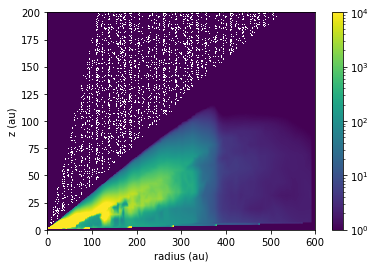

In [44]:
import matplotlib.pyplot as plt
import matplotlib.colors as col

logngasinterp = LinearNDInterpolator(list(zip(rac2d_rvals, rac2d_zvals)), np.log10(rac2d_ngas),fill_value=1.e-20)
rgrid, zgrid = np.mgrid[0:600:300j, 0:200:200j] #specify a regular grid going from r=0 to 600 spaced evenly by 300 gridpoints and z=0 to 200 spaced evenly by 200 gridpoints
simpleCOdistribution = np.zeros_like(rgrid)
for i in range(300):
    for j in range (200):
        ngas = 10**logngasinterp(rgrid[i,j], zgrid[i,j])
        simpleCOdistribution[i,j] = ngas
            
plt.imshow(simpleCOdistribution.T, origin='lower', aspect='auto', norm=col.LogNorm(vmin=1., vmax = 1.e4),
               extent = [np.min(rgrid),np.max(rgrid), np.min(zgrid), np.max(zgrid)])
plt.colorbar()
plt.xlabel('radius (au)')
plt.ylabel('z (au)')
plt.show()

II (2). Running a new RADMC3D model of CO J = 2-1 and exporting it to FITS format.

In [3]:
import sys
import os
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import matplotlib.colors as col
import radmc3dPy.natconst as nc

def setDirectories(molname_in):
    """
    This function creates new directories (if not existed) named by the
    molecule we are studying and changes the current working directory
    to the directory specified in path.
        
    The `molname_in` parameter allows you to edit the name of the directory
    as you wish.
        
    Args:
        molname_in (str) : name [no units] of the molecule that
            we want to investigate.
                
    Returns:
        This function returns nothing.
    """
    path = '/shellstrop1/feilongm/' + molname_in + '_newNumDens'
    if not os.path.exists(path):
        os.system('mkdir ' + path)
    os.chdir(path)

def load_output():
    """
    This function extracts useful infromation in a file called 'iter_0001.dat'
    that describes the chemical and physical properties of a modeling protoplanetary
    disk.
    It creates and then returns a dictionary based on the information in
    'iter_0001.dat' file.
        
    Args:
        This function has no argument.
                
    Returns:
        dictionary (dict) : pairs of various properties and corresponding numerical values
        of the modeling protoplanetary disk. 
    """
    filename='/data/feilongm/rac-2d/rac-2d-master_2021/storage/HD_163296_COdep_t1e4_3/iter_0001.dat'
    output = np.loadtxt(filename, comments='!')
    with open(filename, 'r') as f:
        columnnames = f.readline().split()[1:]
        return dict(zip(np.array(columnnames), output.T))

def saveFile(results):
    """
    This function saves structural information of the modeling protoplanetary disk extracted
    from a dictonary that is passed into this function as a free parameter.
    It also adds a specific path for users to search.
        
    Args:
        results (dict) : pairs of various properties and corresponding numerical values
        of the modeling protoplanetary disk.
                
    Returns:
        This function returns nothing. 
    """
    
    rac2d_rvals = 0.5*(results['rmin']+results['rmax'])
    rac2d_zvals = 0.5*(results['zmin']+results['zmax'])
    rac2d_COabundance = results['n_gas']*results['CO'] #absolute CO abundance in cm^-3
    rac2d_COabundance[rac2d_COabundance<1.e-20] = 1.e-20
    rac2d_COabundance[rac2d_zvals/rac2d_rvals>0.4] = 1.e-20
    rac2d_temp = results['Tgas']
    outputarray = np.stack((rac2d_rvals, rac2d_zvals, rac2d_COabundance, rac2d_temp), axis=-1)

    np.savetxt('/shellstrop1/feilongm/HD163296_radmc3d/HD163296_COstructure.txt',outputarray)
    sys.path.append('/shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy')

def setModelGrid(mstar_in, gasspec_vturb_in):
    """
    This function enables us to create and return a customized model grid using two free
    parameters 'mstar_in' and 'gasspec_vturb_in'.
        
    Args:
        mstar_in (float) : stellar mass in [gram].
        gasspec_vturb_in (float) : turbulent line broadening parameter in [cm/s].
                
    Returns:
        a newly created customized radmc3d model [no units].
    """
    import radmc3dPy.natconst as nc
    rvals = np.logspace(np.log10(0.01), np.log10(800),num=100)
    rvalstring='['
    for i in rvals:
        rvalstring+=('%0.2e' % i + "*au,")
    rvalstring=rvalstring[:-1]+']'
    model = radmc3dPy.setup.radmc3dModel(model='ppdisk', 
                                         mstar = [mstar_in], #custom mstar
                                         gasspec_vturb = gasspec_vturb_in, #custom gasspec_vturb
                                         binary=False)
    model.par.ppar['crd_sys']  = 'sph'
    model.makeGrid()
    model.grid.act_dim = [1,1,0]
    model.grid.nxi = 256
    model.grid.nyi = 65
    model.grid.nzi = 2
    model.grid.xi = np.logspace(np.log10(0.1*nc.au), np.log10(600*nc.au), num=model.grid.nxi)
    model.grid.yi = np.concatenate((np.linspace(0, np.pi/3, num=20)[:-1], np.linspace(np.pi/3., np.pi/2., num=model.grid.nyi+1-20) )) #in radians
    model.grid.zi = np.array([0,0]) 
    model.grid.nx = model.grid.nxi-1
    model.grid.ny = model.grid.nyi-1
    model.grid.nz = model.grid.nzi-1
    model.grid.x = (model.grid.xi[1:]+model.grid.xi[:-1])*0.5
    model.grid.y = (model.grid.yi[1:]+model.grid.yi[:-1])*0.5
    model.grid.z = np.array([0])
    model.grid.writeSpatialGrid()
    model.grid.writeWavelengthGrid()
    model.data = radmc3dPy.analyze.radmc3dData(model.grid)
    model.makeRadSources(writeToFile=True)
    model.makeVar(gvel=True, vturb=True, writeToFile=True)
    return model

def writeGasTemp(radmc3dpy_model, structurefile):
    """
    This function enables us to write desired gas temperature to the model that we specified.
    The second parameter 'structurefile' here is for the convinence of reusing this function 
    in function WriteIn(...) described in this notebook later. It has no use in this particular
    case.
        
    Args:
        radmc3dpy_model (class) : a radmc3d model with various properties and corresponding values.
        structurefile (str) : path to the appropriate file.
                
    Returns:
        This function returns nothing.
    """
    import radmc3dPy.natconst as nc
    nx = radmc3dpy_model.data.grid.nx
    ny = radmc3dpy_model.data.grid.ny
    nz = radmc3dpy_model.data.grid.nz
    radmc3d_temp = np.zeros([nx, ny, nz])
    HD163296structure = np.loadtxt(structurefile)
    rac2d_r = HD163296structure[:,0]*nc.au 
    rac2d_z = HD163296structure[:,1]*nc.au 
    rac2d_temp =  HD163296structure[:,3] 
    
    rac2d_r = np.concatenate((rac2d_r, rac2d_r))
    rac2d_z = np.concatenate((rac2d_z, -1*rac2d_z))
    rac2d_temp =  np.concatenate((rac2d_temp, rac2d_temp))

    
    temp_interp = LinearNDInterpolator(list(zip(rac2d_r, rac2d_z)), rac2d_temp, fill_value=3.)
    
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                r_cyl = radmc3dpy_model.data.grid.x[i]*np.sin(radmc3dpy_model.data.grid.y[j])
                z = np.abs(radmc3dpy_model.data.grid.x[i]*np.cos(radmc3dpy_model.data.grid.y[j]))
                tempval = temp_interp(r_cyl,z)
                if tempval>1.e5:
                    radmc3d_temp[i,j,k] = 99999.
                else:
                    radmc3d_temp[i,j,k] = temp_interp(r_cyl,z)
                
    radmc3dpy_model.data.gastemp = radmc3d_temp
    radmc3dpy_model.data.writeGasTemp(binary=False)
    
def writeCOIsoNumDens(radmc3dpy_model, structurefile, molname, RAF_in):
    """
    This function allows us to use free parameters to generate the density of the isotopologues of CO and write them into the
    model we choose.
    The second parameter 'structurefile' here is for the convinence of reusing this function 
    in function WriteIn(...) described in this notebook later. It has no use in this particular
    case.
        
    Args:
        radmc3dpy_model (class) : a radmc3d model with various properties and corresponding values.
        structurefile (str) : path to the appropriate file.
        molname (str) : name of the molecule [no units].
        RAF_in (float) : relative abundance factor [no units].
        
    Returns:
        This function returns nothing.
    """
    nx = radmc3dpy_model.data.grid.nx
    ny = radmc3dpy_model.data.grid.ny
    nz = radmc3dpy_model.data.grid.nz
    radmc3d_CONumDens = np.zeros([nx, ny, nz])
    HD163296structure = np.loadtxt(structurefile)
    rac2d_r = HD163296structure[:,0]*nc.au #convert from au to cm
    rac2d_z = HD163296structure[:,1]*nc.au #convert from au to cm
    rac2d_ngas = HD163296structure[:,2] #in cm^-3
    
    #mirror the model for the lower half of the disk so interpolation at the midplane is reasonable
    rac2d_r = np.concatenate((rac2d_r, rac2d_r))
    rac2d_z = np.concatenate((rac2d_z, -1*rac2d_z))
    rac2d_ngas =  np.concatenate((rac2d_ngas, rac2d_ngas))
    
    logngasinterp = LinearNDInterpolator(list(zip(rac2d_r, rac2d_z)), np.log10(rac2d_ngas),fill_value=-20)
    
    #here, x, y, and z do NOT refer to Cartesian coordinates, but in this case correspond to the three spherical coordinates
    
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                #convert from spherical to cylindrical coordinates
                r_cyl = radmc3dpy_model.data.grid.x[i]*np.sin(radmc3dpy_model.data.grid.y[j])
                z = np.abs(radmc3dpy_model.data.grid.x[i]*np.cos(radmc3dpy_model.data.grid.y[j]))
                ngas = 10**logngasinterp(r_cyl,z)
                radmc3d_CONumDens[i,j,k] = RAF_in * ngas
    radmc3dpy_model.data.ndens_mol = radmc3d_CONumDens
    radmc3dpy_model.data.writeGasDens(ispec=molname,binary=False)

def writeIn(model_in, molname_in, RAF_in):
    """
    This function encapsulates function writeGasTemp(...) and writeMolNumDens(...). It is for the
    purpose of bing used as a "summative function" to reduce code redundancy.
        
    Args:
        model_in (class) : a radmc3d model with various properties and corresponding values.
        molname_in (str) : name of the molecule [no units].
        RAF_in (float) : relative abundance factor [no units].
                
    Returns:
        This function returns nothing.
    """
    HD163296file = '/shellstrop1/feilongm/HD163296_radmc3d/HD163296_COstructure.txt' #change to appropriate path as needed
    writeGasTemp(model_in, HD163296file)
    writeCOIsoNumDens(model_in, HD163296file, molname_in, RAF_in)

def copyDataAndWriteFile(molname_in, model_in):
    """
    This function copies over a certain molecule's line data to directories specified by the name of the molecule and
    writes radmc3d input files.
        
    Args:
        molname_in (str) : name of the molecule [no units].
        model_in (class) : a radmc3d model with various properties and corresponding values.
                
    Returns:
        This function returns nothing.
    """
    import os.path
    from os import path
    filename = 'molecule_'+ molname_in +'.inp'
    path = '/home/feilongm/' + filename
    if molname_in == 'co':
        os.system('cp -v /shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy/python_examples/datafiles/molecule_co.inp .') # change to correct path
    elif os.path.exists(filename):
        os.system('cp -v ' + path)
    model_in.par.ppar['gasspec_mol_name'] = [molname_in]
    model_in.writeLinesInp()
    model_in.par.ppar['lines_mode']=1
    model_in.par.ppar['tgas_eq_tdust']=0
    model_in.writeRadmc3dInp()

def simulateImageCube(incl_in, widthkms_in, linenlam_in, iline_in):
    """
    This function simulates an image cube.
        
    Args:
        incl_in (float) : disk inclination angle in [degree].
        widthkms_in (float) : frequency converted to velocity [km/s] using rest frequency.
        linenlam_in (int) : number of wavelengths [no units] at which to calculate the spectrum.
        iline_in (int) : number of molecular transition to simulate [no units].
                
    Returns:
        This function returns nothing.
    """
    radmc3dPy.image.makeImage(npix=1024.,
                          incl=incl_in,
                          phi=0.,
                          sizeau=1500.,
                          widthkms=widthkms_in,
                          linenlam=linenlam_in,
                          iline=iline_in)
    
def saveAsFits(molname_in):
    """
    This function saves different molecule image output files as fits files.
        
    Args:
        model_in (class) : a radmc3d model with various properties and corresponding values.
                
    Returns:
        This function returns nothing.
    """
    im = radmc3dPy.image.readImage(fname='/shellstrop1/feilongm/' + molname_in + '_newNumDens' + '/image.out') #edit to match the path to the image
    im.writeFits('testimage' + molname_in + '.fits', dpc=101., coord='17h56m21s -21d57m21s')

In [4]:
def RADMC3D(molname_in, iline_in, mstar_in, gasspec_vturb_in, incl_in, widthkms_in, linenlam_in, RAF):
    """
    This function glues all the functions described in the previous cell together to 
    reduce a lot of code redundancies in generating models with various combinations of
    parameters.
        
    Args:
        molname_in (str) : name of the molecule [no units].
        iline_in (int) : number of molecular transition to simulate [no units].
        mstar_in (float) : stellar mass in [gram].
        gasspec_vturb_in (float) : turbulent line broadening parameter in [cm/s].
        incl_in (float) : disk inclination angle in [degree].
        widthkms_in (float) : frequency converted to velocity [km/s] using rest frequency.
        linenlam_in (int) : number of wavelengths [no units] at which to calculate the spectrum.
        RAF_in (float) : relative abundance factor [no units].
                
    Returns:
        This function returns nothing.
    """
    setDirectories(molname_in)
    results = load_output()
    saveFile(results)
    model_in = setModelGrid(mstar_in, gasspec_vturb_in)
    writeIn(model_in, molname_in, RAF_in)
    copyDataAndWriteFile(molname_in, model_in)
    simulateImageCube(incl_in, widthkms_in, linenlam_in, iline_in)
    saveAsFits(molname_in)

In [6]:
molname_in = 'co'
iline_in = 2
mstar_in = 4.e33
gasspec_vturb_in = 1.e4
incl_in = 46.7
widthkms_in = 10
linenlam_in = 81
RAF_in = 1.

RADMC3D(molname_in, iline_in, mstar_in, gasspec_vturb_in, incl_in, widthkms_in, linenlam_in, RAF_in)

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 1024 incl 46.7 sizeau 1500.0 widthkms 10 linenlam 81 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading /shellstrop1/feilongm/co_newNumDens/image.out
testimageco.fits already exists
Do you want to overwrite it (yes/no)?yes


In [6]:
molname_in = '13co'
iline_in = 2
mstar_in = 4.e33
gasspec_vturb_in = 1.e4
incl_in = 46.7
widthkms_in = 10
linenlam_in = 81
RAF_in = 1 / 69

RADMC3D(molname_in, iline_in, mstar_in, gasspec_vturb_in, incl_in, widthkms_in, linenlam_in, RAF_in)

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_13co.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 1024 incl 46.7 sizeau 1500.0 widthkms 10 linenlam 81 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading /shellstrop1/feilongm/13co_newNumDens/image.out
testimage13co.fits already exists
Do you want to overwrite it (yes/no)?yes


In [7]:
molname_in = 'c18o'
iline_in = 2
mstar_in = 4.e33
gasspec_vturb_in = 1.e4
incl_in = 46.7
widthkms_in = 10
linenlam_in = 81
RAF_in = 1 / (69 * 8)

RADMC3D(molname_in, iline_in, mstar_in, gasspec_vturb_in, incl_in, widthkms_in, linenlam_in, RAF_in)

Writing problem_params.inp
Writing amr_grid.inp
Writing wavelength_micron.inp
Writing stars.inp
-------------------------------------------------------------
Luminosities of radiation sources in the model :
Reading wavelength_micron.inp
As calculated from the input files :
Stars : 
  Star #0 + hotspot        : 3.564346e+33
Continuous starlike source : 0.000000e+00
 
-------------------------------------------------------------
Writing gas_velocity.inp
Writing microturbulence.inp
Writing gas_temperature.inp
Writing numberdens_c18o.inp
Writing lines.inp
Writing radmc3d.inp
Executing RADMC-3D Command:
radmc3d image npix 1024 incl 46.7 sizeau 1500.0 widthkms 10 linenlam 81 phi 0.0 pointau 0.0  0.0  0.0 fluxcons iline 2
Reading /shellstrop1/feilongm/c18o_newNumDens/image.out


Part III. Convolving model images.

In [4]:
im = radmc3dPy.image.readImage(fname='/shellstrop1/feilongm/co_newNumDens/image.out')
cim = im.imConv(fwhm=[0.15, 0.15], pa=0., dpc=101.)
cim.writeFits('/shellstrop1/feilongm/co_newNumDens/12CO_convolved.fits', dpc=101., coord='17h56m21s -21d57m21s', nu0 = 230.538e9)

Reading /shellstrop1/feilongm/co_newNumDens/image.out


In [5]:
im = radmc3dPy.image.readImage(fname='/shellstrop1/feilongm/13co_newNumDens/image.out')
cim = im.imConv(fwhm=[0.15, 0.15], pa=0., dpc=101.)
cim.writeFits('/shellstrop1/feilongm/13co_newNumDens/13CO_convolved.fits', dpc=101., coord='17h56m21s -21d57m21s', nu0 = 230.538e9)

Reading /shellstrop1/feilongm/13co_newNumDens/image.out


In [6]:
im = radmc3dPy.image.readImage(fname='/shellstrop1/feilongm/c18o_newNumDens/image.out')
cim = im.imConv(fwhm=[0.15, 0.15], pa=0., dpc=101.)
cim.writeFits('/shellstrop1/feilongm/c18o_newNumDens/C18O_convolved.fits', dpc=101., coord='17h56m21s -21d57m21s', nu0 = 230.538e9)

Reading /shellstrop1/feilongm/c18o_newNumDens/image.out


Part IV. Looking at the surfaces of CO isotopologue models.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from diskprojection import disk_observation
from itertools import product

def Plotting_emission_surface_v2(path_in):
    """
    This function plots the emission surface of CO isotopologues using datapoints spanning across all channels.
    It takes in four parameters.
    Get_emission_surface(...) function is now upgraded to version 3.
    
    Args:
        path_in (str): name[no units] of directory holding the real ALMA observational images
        
    Returns:
        This function returns nothing.
    """
    HD163296_molecule = disk_observation(path_in)
    r, z, Fnu, velocity, x, yf, yn = HD163296_molecule.get_emission_surface_v3(inc=46.7, PA=90, chans = [0, 80], r_max = 5., min_Fnu = 0.0001)
    fig = plt.figure(figsize=(100, 130))
    for index, velo in enumerate(np.unique(velocity)):
        rvals_tofit = r[np.where(velocity==velo)]
        zvals_tofit = z[np.where(velocity==velo)]
        i = 0
        ax = plt.subplot(9, 9, index+1)
        ax.scatter(rvals_tofit, zvals_tofit,s=3)
        ax.set_xlabel('r (arcsec)')
        ax.set_ylabel('z (arcsec)')
        ax.text(0.75, 0.9, "%.2f km/s" % (velo/1000.), transform=ax.transAxes)
    plt.show()

In [6]:
import sys
sys.path.append('/shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy') #edit to match your path

import radmc3dPy

im = radmc3dPy.image.readImage(fname='/shellstrop1/feilongm/co_newNumDens/image.out') #edit to match the path to the image
#edit to match where you want the image to be saved
im.writeFits('/shellstrop1/feilongm/co_newNumDens/12CO_convolved.fits', dpc=101., coord='17h56m21s -21d57m21s', nu0 = 230.538e9)

Reading /shellstrop1/feilongm/co_newNumDens/image.out
/shellstrop1/feilongm/co_newNumDens/12CO_convolved.fits already exists
Do you want to overwrite it (yes/no)?yes


In [7]:
import sys
sys.path.append('/shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy') #edit to match your path

import radmc3dPy

im = radmc3dPy.image.readImage(fname='/shellstrop1/feilongm/13co_newNumDens/image.out') #edit to match the path to the image
#edit to match where you want the image to be saved
im.writeFits('/shellstrop1/feilongm/13co_newNumDens/13CO_convolved.fits', dpc=101., coord='17h56m21s -21d57m21s', nu0 = 220.3986841281e9)

Reading /shellstrop1/feilongm/13co_newNumDens/image.out
/shellstrop1/feilongm/13co_newNumDens/13CO_convolved.fits already exists
Do you want to overwrite it (yes/no)?yes


In [8]:
import sys
sys.path.append('/shellstrop1/feilongm/radmc3d-2.0-master/python/radmc3dPy') #edit to match your path

import radmc3dPy

im = radmc3dPy.image.readImage(fname='/shellstrop1/feilongm/c18o_newNumDens/image.out') #edit to match the path to the image
#edit to match where you want the image to be saved
im.writeFits('/shellstrop1/feilongm/c18o_newNumDens/C18O_convolved.fits', dpc=101., coord='17h56m21s -21d57m21s', nu0 = 219.5603541e9)

Reading /shellstrop1/feilongm/c18o_newNumDens/image.out
/shellstrop1/feilongm/c18o_newNumDens/C18O_convolved.fits already exists
Do you want to overwrite it (yes/no)?yes


In [9]:
path_1 = '/shellstrop1/feilongm/co_newNumDens/12CO_convolved.fits'
path_2 = '/shellstrop1/feilongm/13co_newNumDens/13CO_convolved.fits'
path_3 = '/shellstrop1/feilongm/c18o_newNumDens/C18O_convolved.fits'

In [20]:
from astropy.io import fits
import numpy as np
from numpy import array, newaxis
from astropy import units as u
import matplotlib.pyplot as plt

HD163296_test_file = "/shellstrop1/feilongm/co_newNumDens/12CO_convolved.fits"

HD163296_testcube = fits.open(HD163296_test_file)[0]

data = HD163296_testcube.data
data = np.squeeze(data)
spectrum = np.sum(data, axis=(1,2))

header = HD163296_testcube.header
print(header)

print("Reference frequency:",header['CRVAL3'] * u.Hz)
print("Reference frequency channel:",header['CRPIX3'])
print("Frequency spacing:",header['CDELT3'] * u.Hz)
print("Number of different frequencies:",header['NAXIS3'])
print("Unit of frequency:",header['CUNIT3'])
RESTFRQ = 230.5380000 * 10**9 *u.Hz
print(RESTFRQ)
numchannels = header['NAXIS3']

FrequencySpacing = header['CDELT3'] * u.Hz
ReferenceFrequency = header['CRVAL3'] * u.Hz
NumFreq = np.arange(start=1, stop=82, step=1)
RestFreq = RESTFRQ
c = 299792.458 * u.km / u.s

def FrequenciesOnDifferentChannals(FrequencySpacing, ReferenceFrequency, NumFreq):
    Freq = ReferenceFrequency + (NumFreq - 1) * FrequencySpacing
    return Freq

ResultReferenceFreq = FrequenciesOnDifferentChannals(FrequencySpacing, ReferenceFrequency, NumFreq)

print(ResultReferenceFreq)

def ConvertingUnits(ResultReferenceFreq, RestFreq):
    ConvertingUnits = c * (RestFreq - ResultReferenceFreq) / RestFreq
    return ConvertingUnits

resultVelocity = ConvertingUnits(ResultReferenceFreq, RestFreq)
print(resultVelocity)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  NAXIS3  =                   81                                                  EXTEND  =                    T                                                  CRPIX1  =                512.5 /                                                CDELT1  = -4.0287231848184E-06                                                  CRVAL1  =             269.0875                                                  CUNIT1  = '     DEG'                                                            CTYPE1  = 'RA---SIN'                                                            CRPIX2  =                512.5          

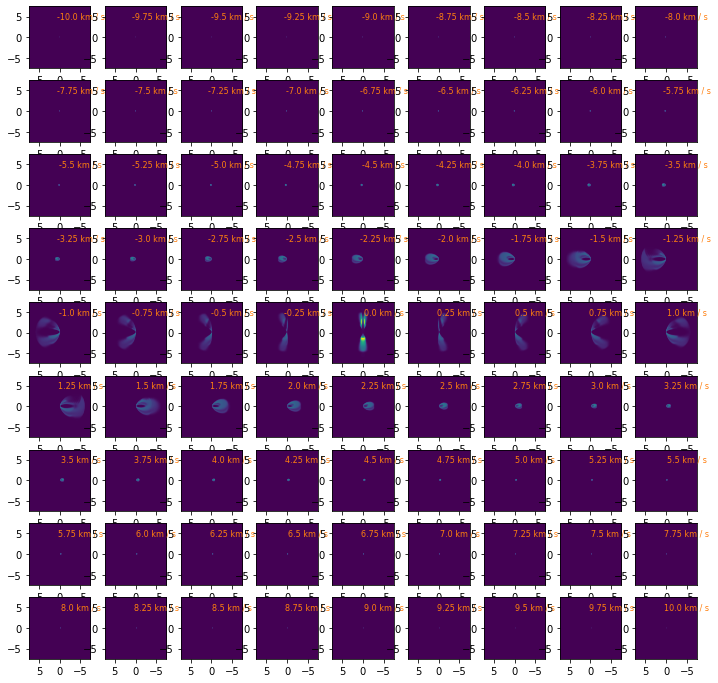

In [21]:
text_kwargs = dict(ha='center', va='center', fontsize=8, color='C1')
plt.figure(figsize = (12,12))
naxis1 = header['NAXIS1']
cdelt1 = header['CDELT1']*3600 #conversion to arcseconds
cdelt2 = header['CDELT2']*3600 #conversion to arcseconds
for i in range(1, 82):
    plt.subplot(9,9,i)
    plt.imshow(data[i-1], origin='lower', extent = [-0.5*cdelt1*naxis1, 0.5*cdelt1*naxis1,-0.5*cdelt2*naxis1, 0.5*cdelt2*naxis1] )
    text = np.round(resultVelocity[i-1], 2)
    plt.text(-5, 5, text, **text_kwargs)
plt.show()

Using -10.00 km/s to 10.00 km/s, and 0.00" to 5.00".
Detecting peaks...


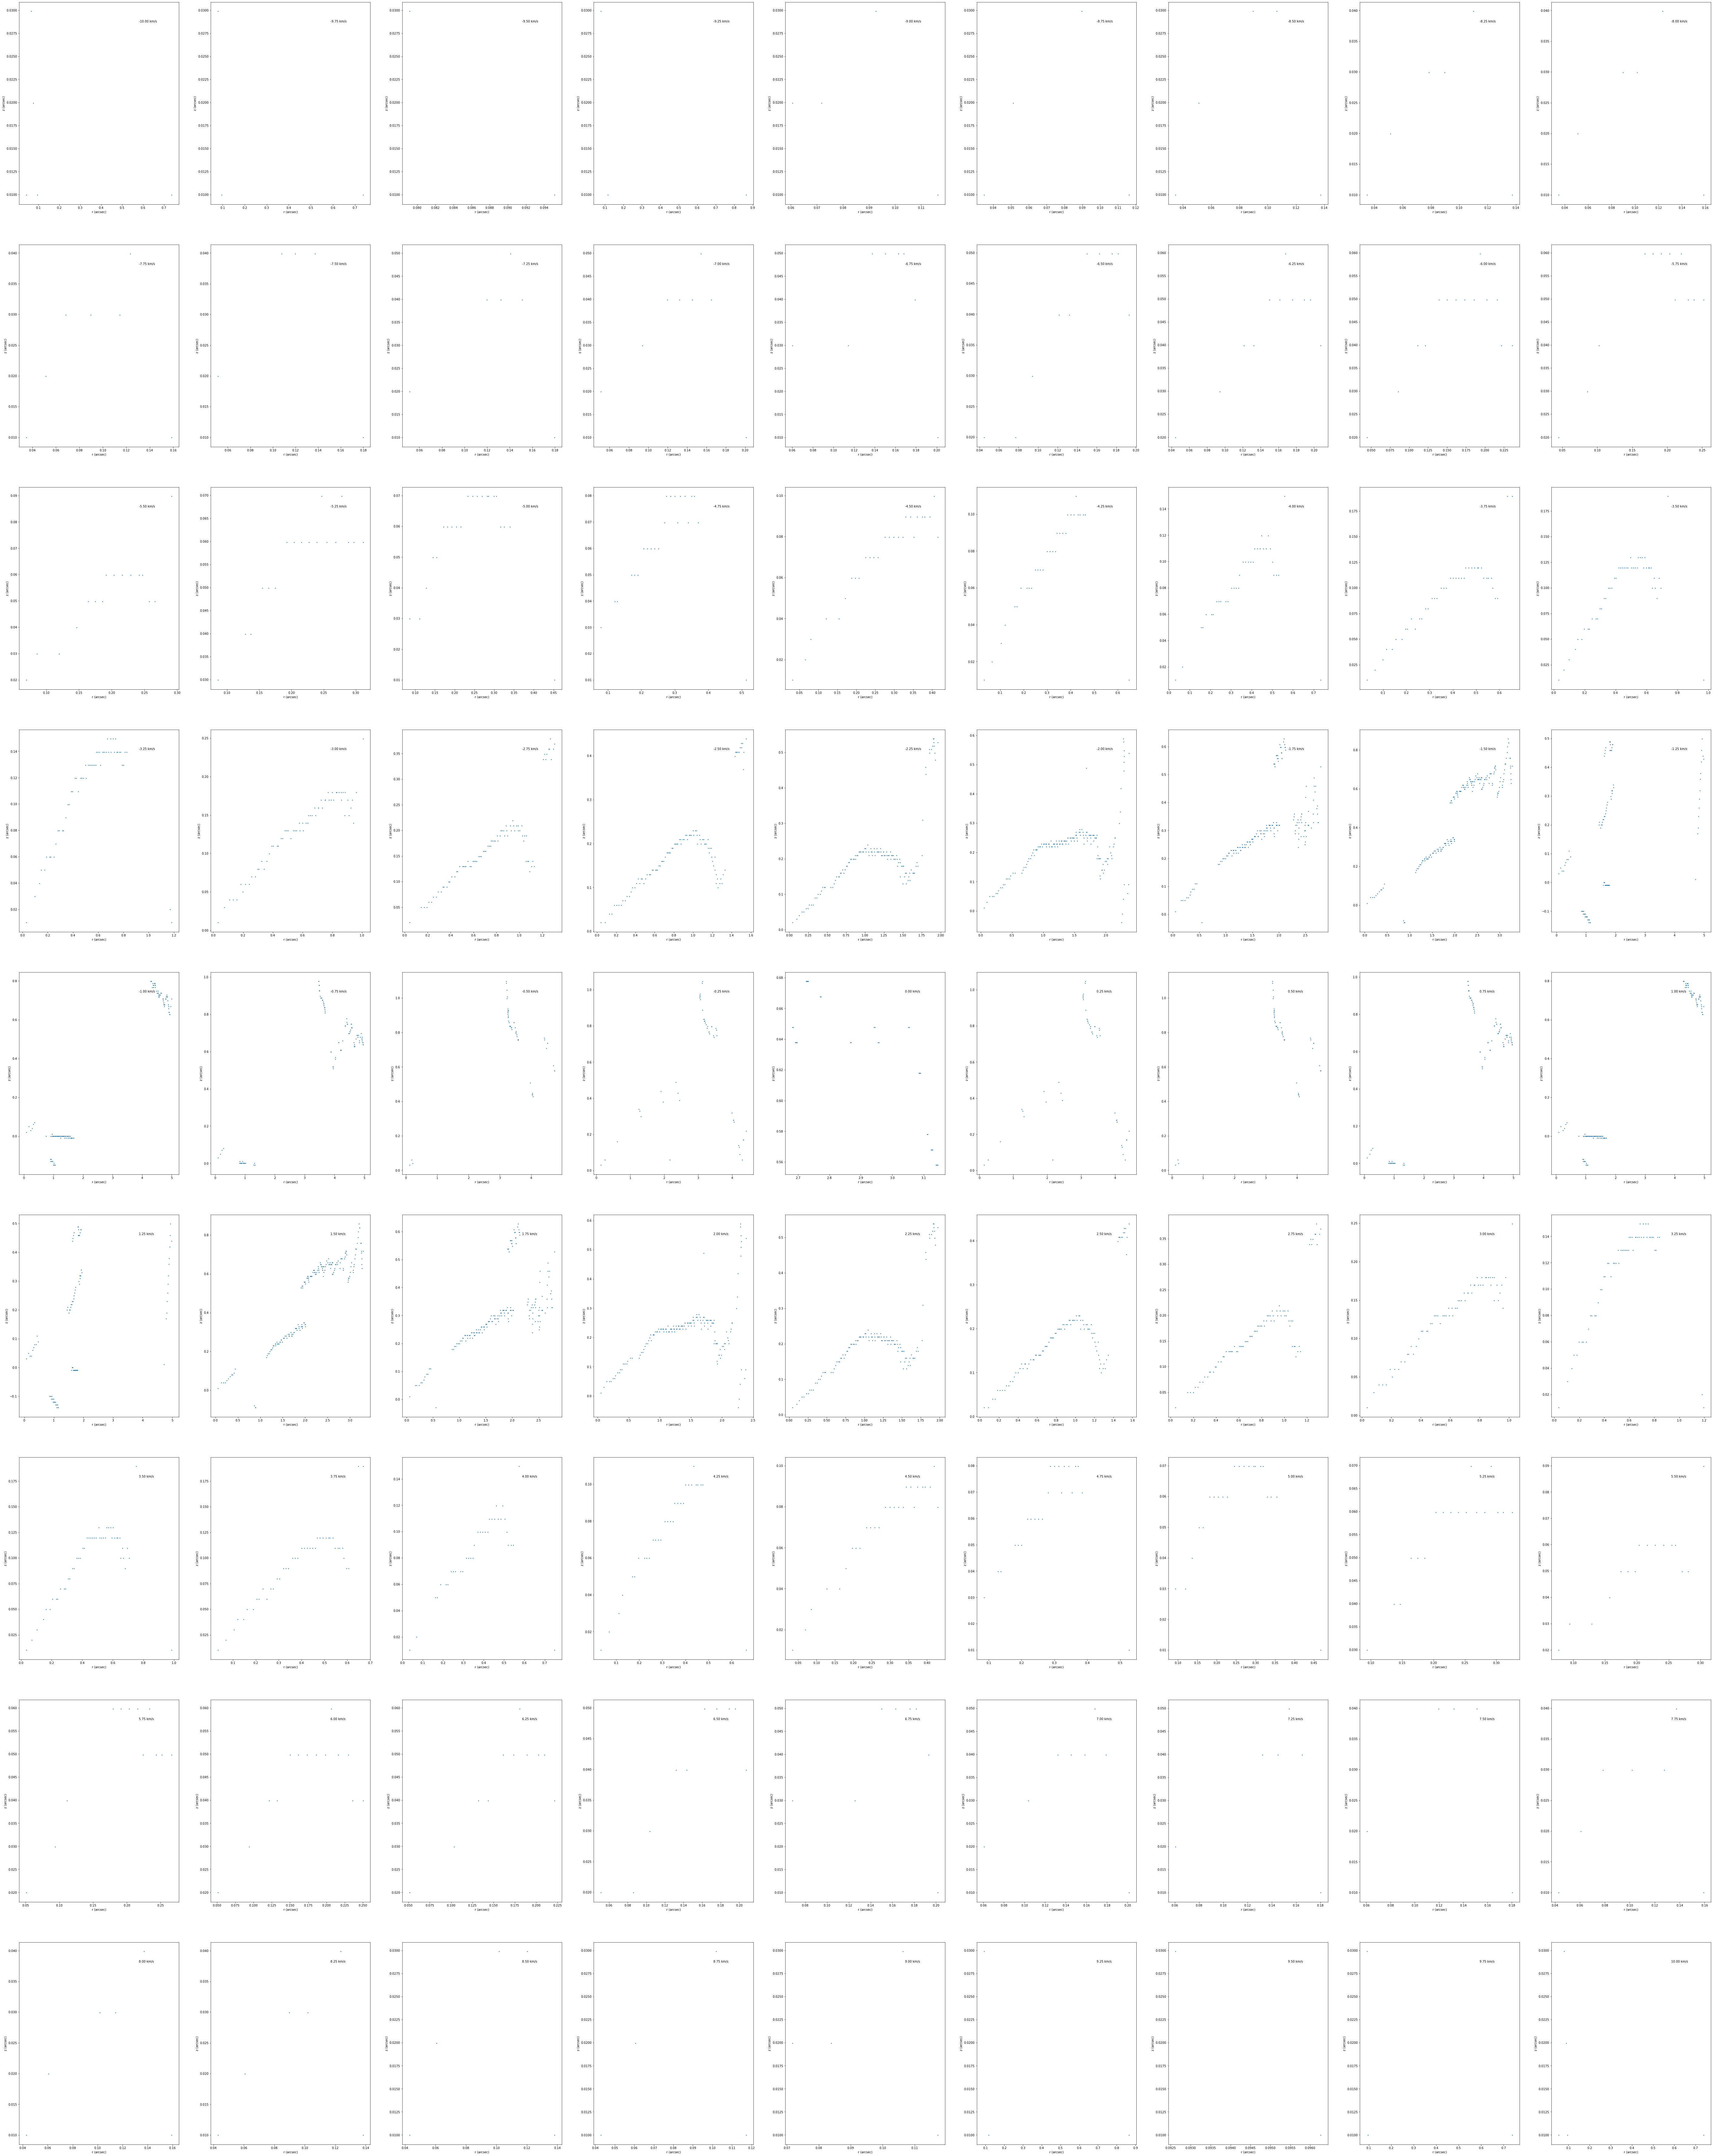

In [22]:
Plotting_emission_surface_v2(path_1)

In [10]:
from astropy.io import fits
import numpy as np
from numpy import array, newaxis
from astropy import units as u
import matplotlib.pyplot as plt

HD163296_test_file = "/shellstrop1/feilongm/13co_newNumDens/13CO_convolved.fits"

HD163296_testcube = fits.open(HD163296_test_file)[0]

data = HD163296_testcube.data
data = np.squeeze(data)
spectrum = np.sum(data, axis=(1,2))

header = HD163296_testcube.header
print(header)

print("Reference frequency:",header['CRVAL3'] * u.Hz)
print("Reference frequency channel:",header['CRPIX3'])
print("Frequency spacing:",header['CDELT3'] * u.Hz)
print("Number of different frequencies:",header['NAXIS3'])
print("Unit of frequency:",header['CUNIT3'])
RESTFRQ = 220.3986841281 * 10**9 *u.Hz
print(RESTFRQ)
numchannels = header['NAXIS3']

FrequencySpacing = header['CDELT3'] * u.Hz
ReferenceFrequency = header['CRVAL3'] * u.Hz
NumFreq = np.arange(start=1, stop=82, step=1)
RestFreq = RESTFRQ
c = 299792.458 * u.km / u.s

def FrequenciesOnDifferentChannals(FrequencySpacing, ReferenceFrequency, NumFreq):
    Freq = ReferenceFrequency + (NumFreq - 1) * FrequencySpacing
    return Freq

ResultReferenceFreq = FrequenciesOnDifferentChannals(FrequencySpacing, ReferenceFrequency, NumFreq)

print(ResultReferenceFreq)

def ConvertingUnits(ResultReferenceFreq, RestFreq):
    ConvertingUnits = c * (RestFreq - ResultReferenceFreq) / RestFreq
    return ConvertingUnits

resultVelocity = ConvertingUnits(ResultReferenceFreq, RestFreq)
print(resultVelocity)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  NAXIS3  =                   81                                                  EXTEND  =                    T                                                  CRPIX1  =                512.5 /                                                CDELT1  = -4.0287231848184E-06                                                  CRVAL1  =             269.0875                                                  CUNIT1  = '     DEG'                                                            CTYPE1  = 'RA---SIN'                                                            CRPIX2  =                512.5          

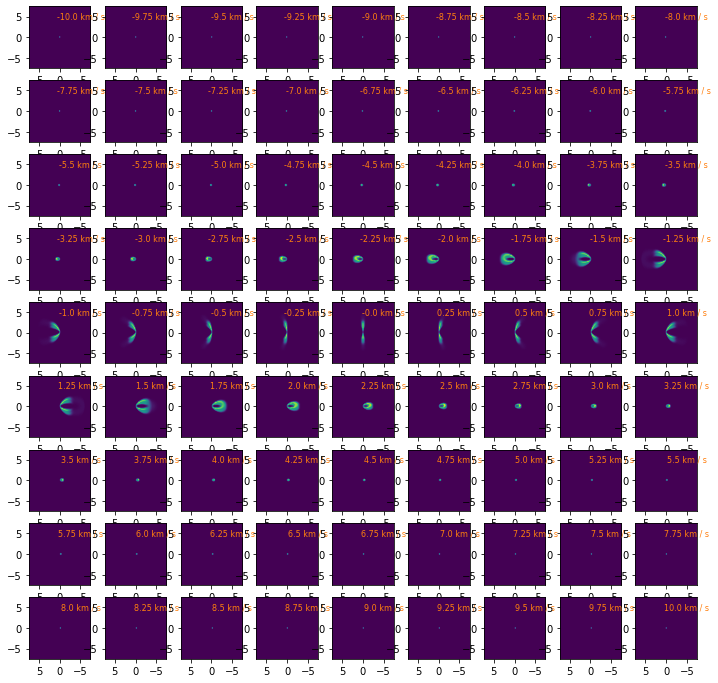

In [11]:
text_kwargs = dict(ha='center', va='center', fontsize=8, color='C1')
plt.figure(figsize = (12,12))
naxis1 = header['NAXIS1']
cdelt1 = header['CDELT1']*3600 #conversion to arcseconds
cdelt2 = header['CDELT2']*3600 #conversion to arcseconds
for i in range(1, 82):
    plt.subplot(9,9,i)
    plt.imshow(data[i-1], origin='lower', extent = [-0.5*cdelt1*naxis1, 0.5*cdelt1*naxis1,-0.5*cdelt2*naxis1, 0.5*cdelt2*naxis1] )
    text = np.round(resultVelocity[i-1], 2)
    plt.text(-5, 5, text, **text_kwargs)
plt.show()

Using -10.00 km/s to 10.00 km/s, and 0.00" to 5.00".
Detecting peaks...


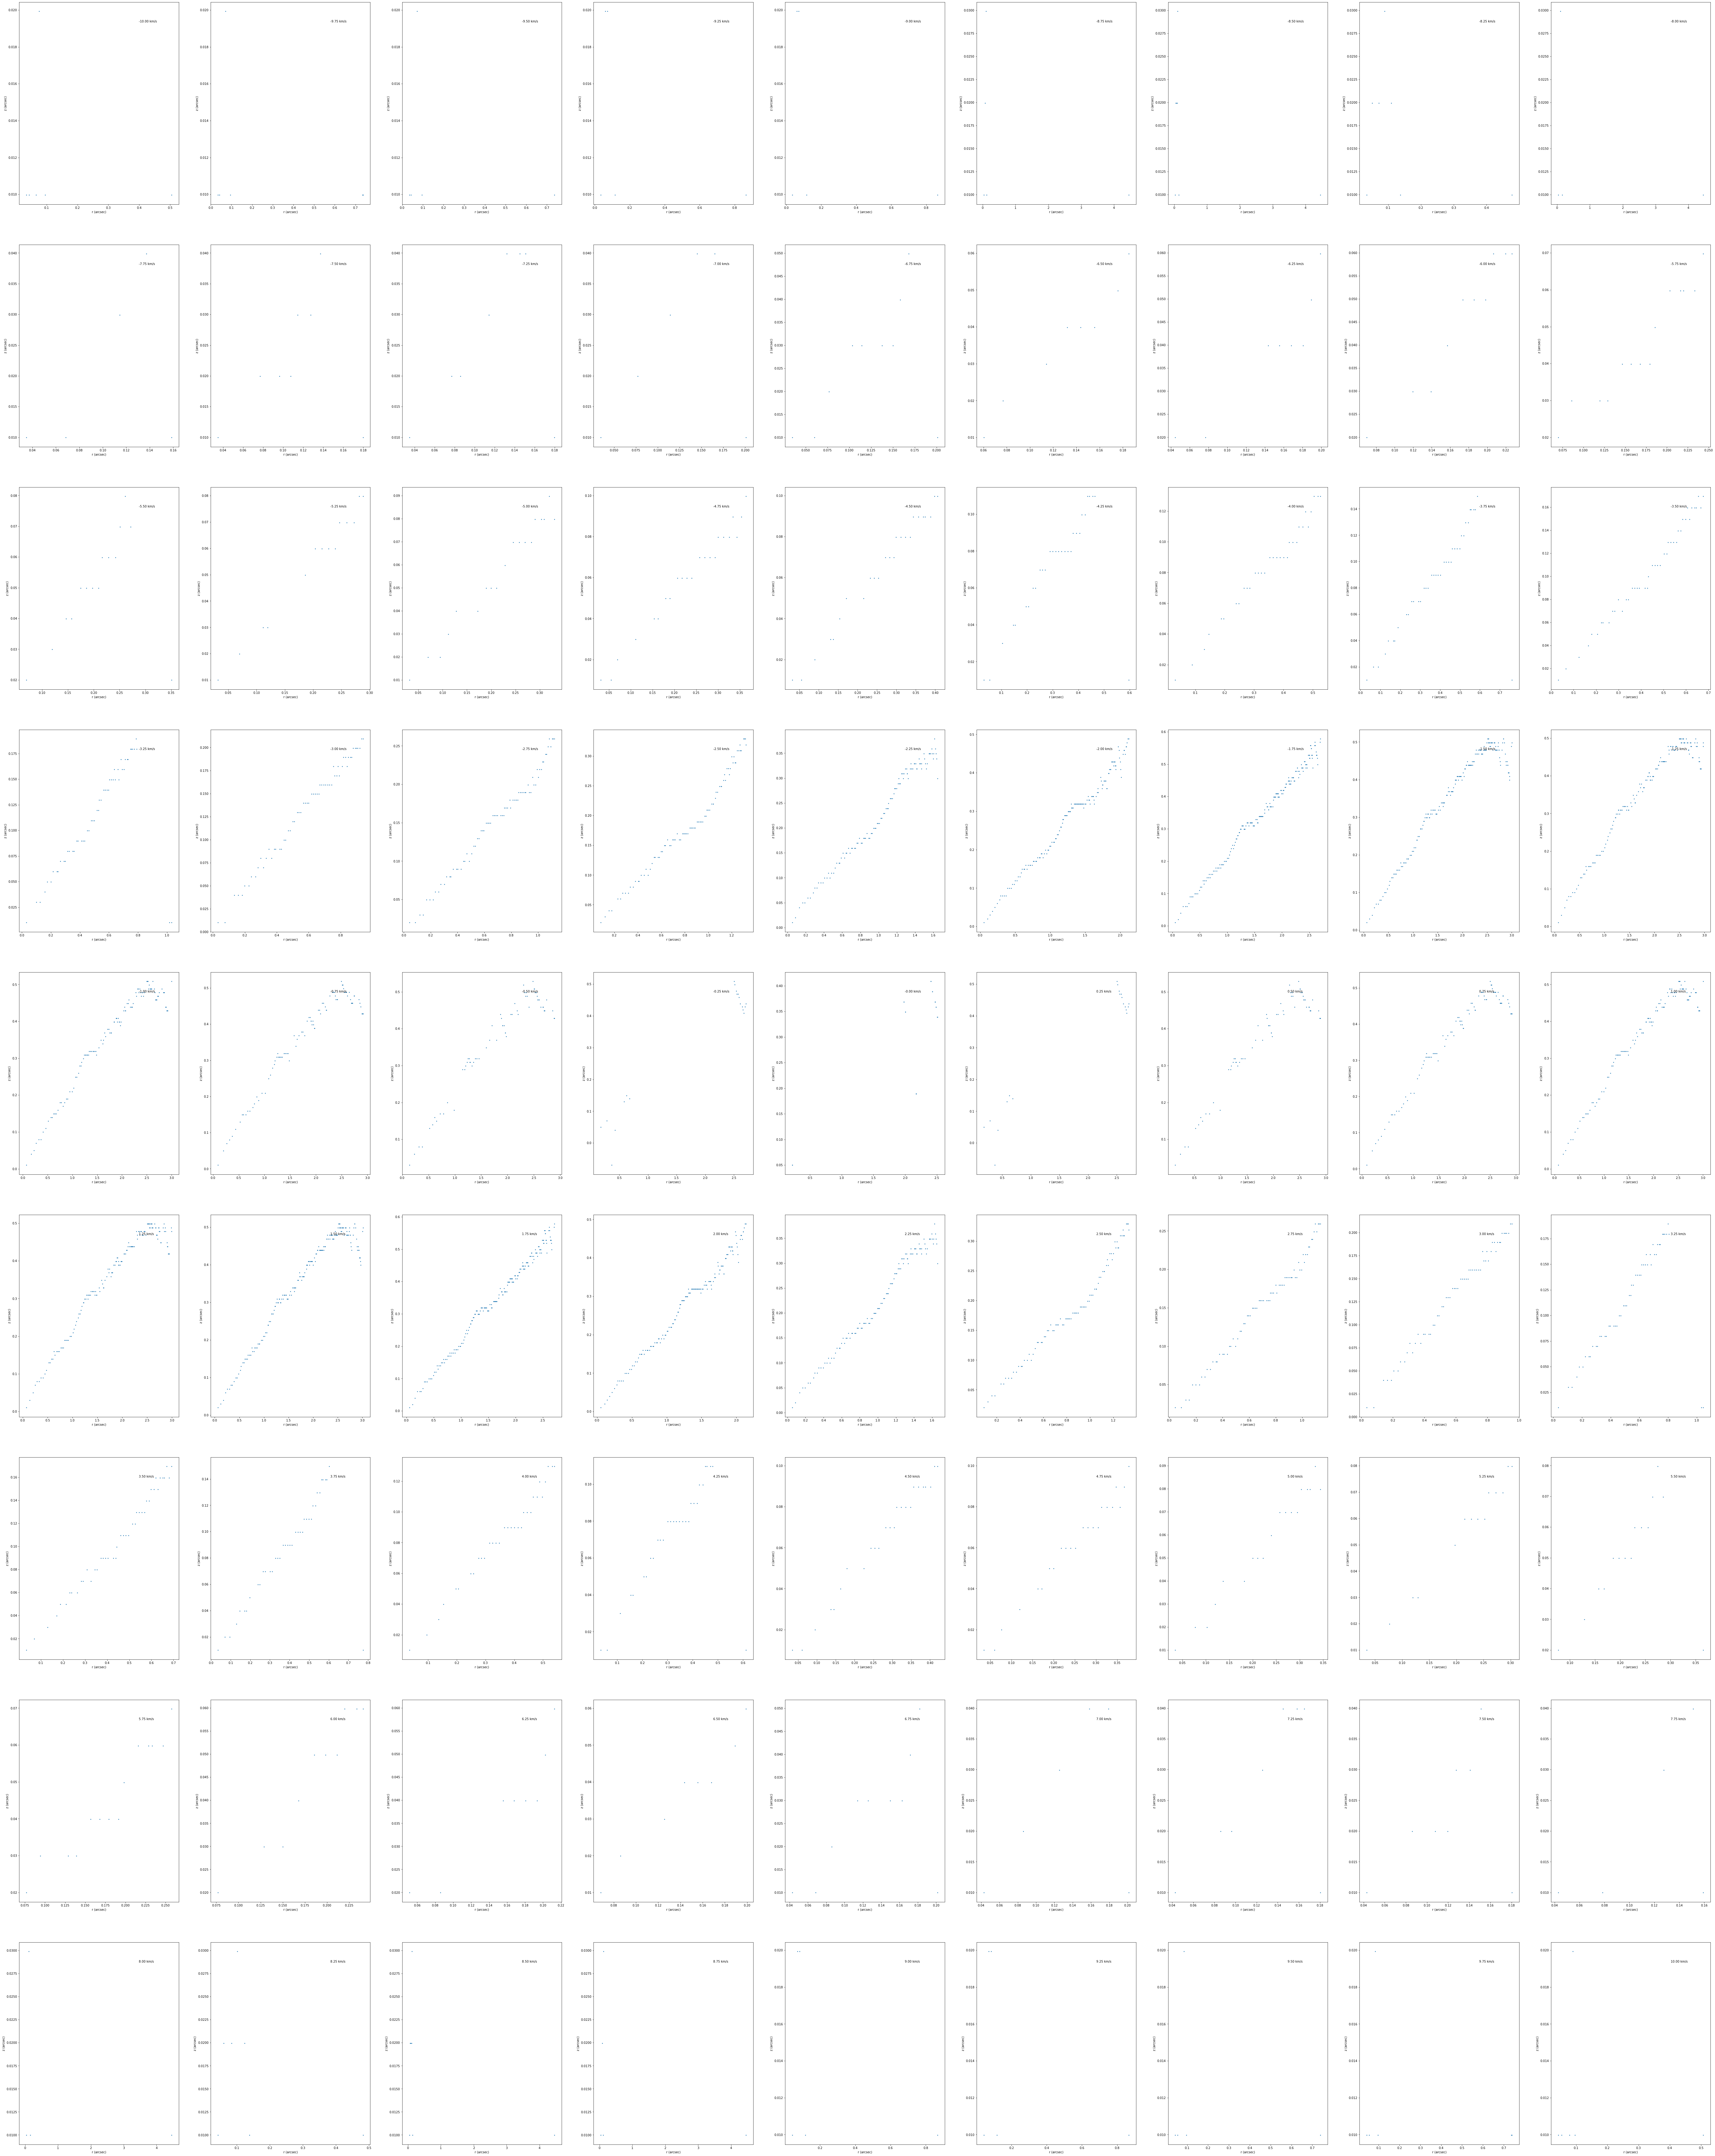

In [18]:
Plotting_emission_surface_v2(path_2)

In [12]:
from astropy.io import fits
import numpy as np
from numpy import array, newaxis
from astropy import units as u
import matplotlib.pyplot as plt

HD163296_test_file = "/shellstrop1/feilongm/c18o_newNumDens/C18O_convolved.fits"

HD163296_testcube = fits.open(HD163296_test_file)[0]

data = HD163296_testcube.data
data = np.squeeze(data)
spectrum = np.sum(data, axis=(1,2))

header = HD163296_testcube.header
print(header)

print("Reference frequency:",header['CRVAL3'] * u.Hz)
print("Reference frequency channel:",header['CRPIX3'])
print("Frequency spacing:",header['CDELT3'] * u.Hz)
print("Number of different frequencies:",header['NAXIS3'])
print("Unit of frequency:",header['CUNIT3'])
RESTFRQ = 219.5603541 * 10**9 *u.Hz
print(RESTFRQ)
numchannels = header['NAXIS3']

FrequencySpacing = header['CDELT3'] * u.Hz
ReferenceFrequency = header['CRVAL3'] * u.Hz
NumFreq = np.arange(start=1, stop=82, step=1)
RestFreq = RESTFRQ
c = 299792.458 * u.km / u.s

def FrequenciesOnDifferentChannals(FrequencySpacing, ReferenceFrequency, NumFreq):
    Freq = ReferenceFrequency + (NumFreq - 1) * FrequencySpacing
    return Freq

ResultReferenceFreq = FrequenciesOnDifferentChannals(FrequencySpacing, ReferenceFrequency, NumFreq)

print(ResultReferenceFreq)

def ConvertingUnits(ResultReferenceFreq, RestFreq):
    ConvertingUnits = c * (RestFreq - ResultReferenceFreq) / RestFreq
    return ConvertingUnits

resultVelocity = ConvertingUnits(ResultReferenceFreq, RestFreq)
print(resultVelocity)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  NAXIS3  =                   81                                                  EXTEND  =                    T                                                  CRPIX1  =                512.5 /                                                CDELT1  = -4.0287231848184E-06                                                  CRVAL1  =             269.0875                                                  CUNIT1  = '     DEG'                                                            CTYPE1  = 'RA---SIN'                                                            CRPIX2  =                512.5          

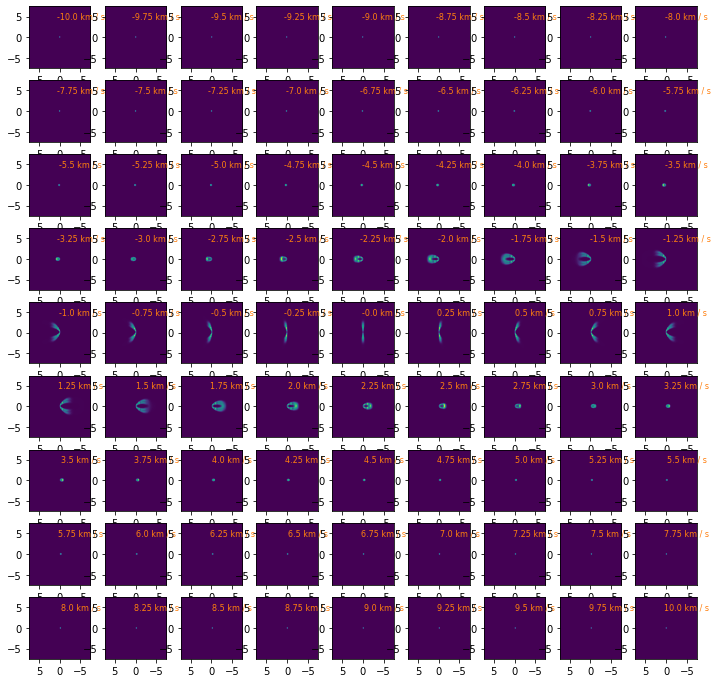

In [13]:
text_kwargs = dict(ha='center', va='center', fontsize=8, color='C1')
plt.figure(figsize = (12,12))
naxis1 = header['NAXIS1']
cdelt1 = header['CDELT1']*3600 #conversion to arcseconds
cdelt2 = header['CDELT2']*3600 #conversion to arcseconds
for i in range(1, 82):
    plt.subplot(9,9,i)
    plt.imshow(data[i-1], origin='lower', extent = [-0.5*cdelt1*naxis1, 0.5*cdelt1*naxis1,-0.5*cdelt2*naxis1, 0.5*cdelt2*naxis1] )
    text = np.round(resultVelocity[i-1], 2)
    plt.text(-5, 5, text, **text_kwargs)
plt.show()

Using -10.00 km/s to 10.00 km/s, and 0.00" to 5.00".
Detecting peaks...


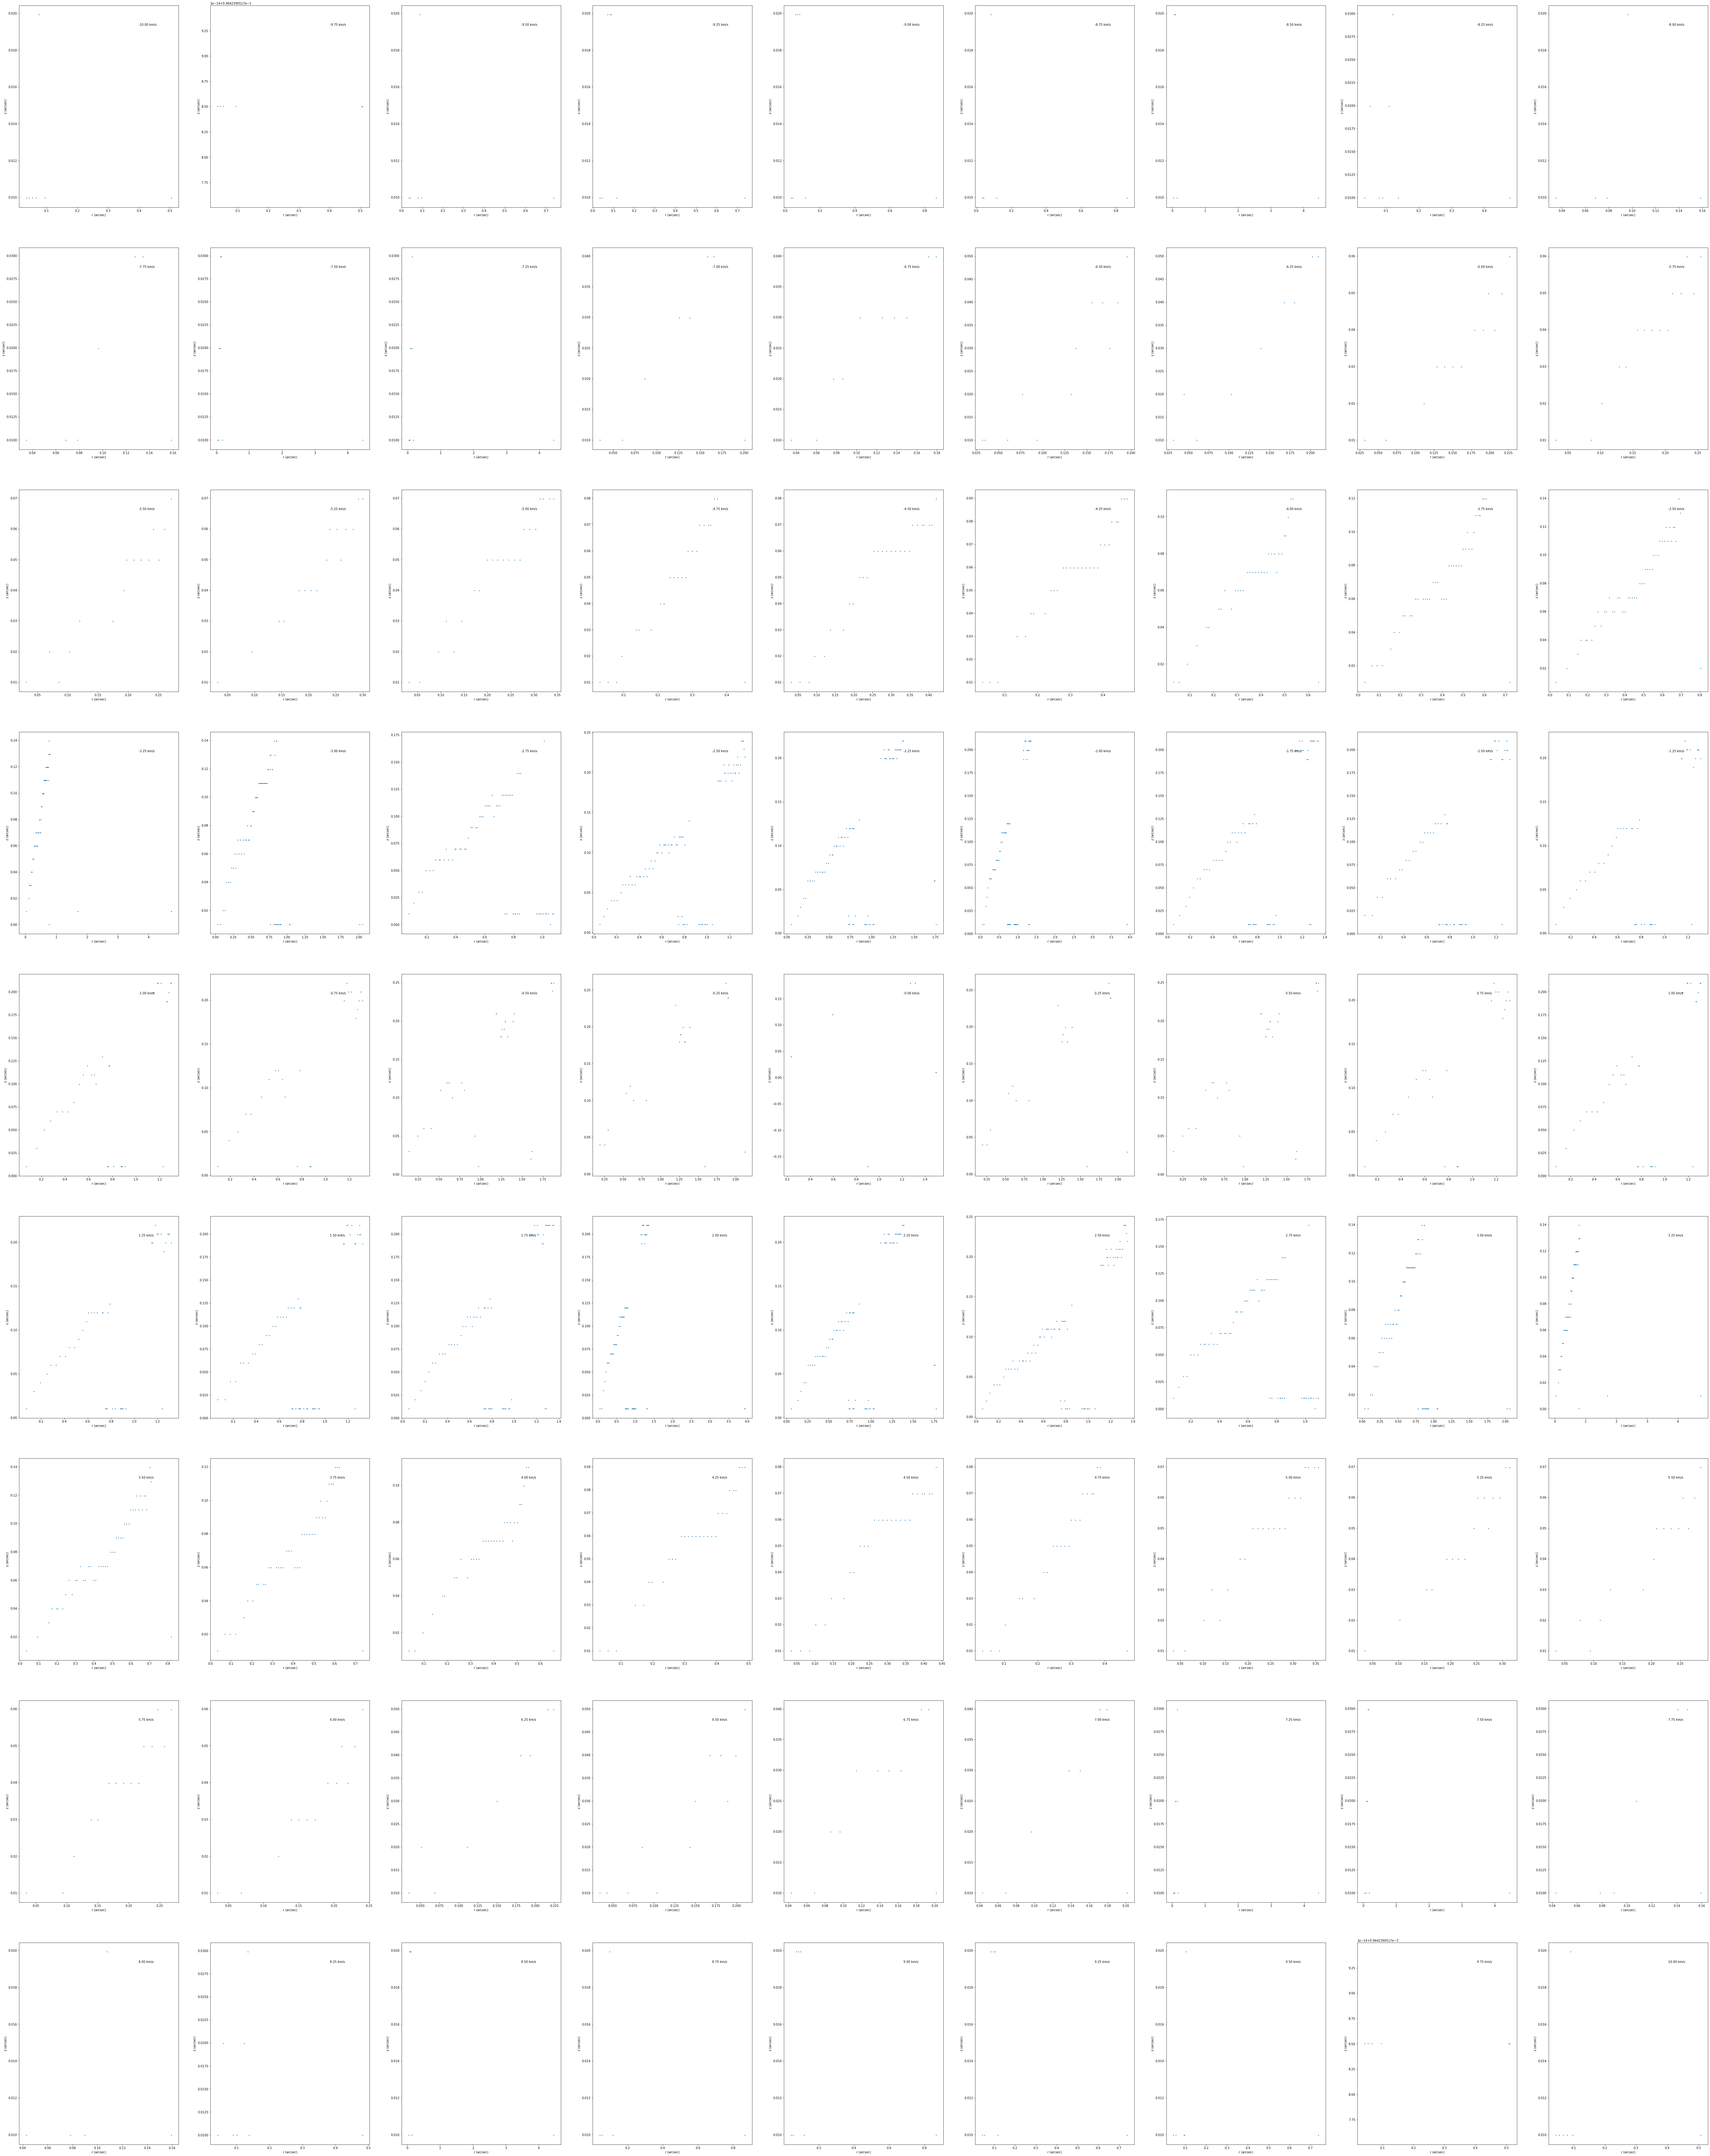

In [23]:
Plotting_emission_surface_v2(path_3)